# Fine-Tuning the Wav2Vec2 Model for Emotional Classification with the RAVDESS Dataset

Used this guide from the keras documentation:
https://keras.io/examples/audio/wav2vec2_audiocls/

In [74]:
import random
import logging

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [75]:
from datasets import load_dataset

dataset = load_dataset("narad/ravdess")

In [43]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender'],
        num_rows: 1440
    })
})

# Data Normalization

Need to get all samples to the same length, then convert to waveform for input to the model

In [76]:
def get_max_length(dataset):
    max_length = 0
    for sample in dataset:
        audio_length = len(sample['audio']['array']) / sample['audio']['sampling_rate']
        if audio_length > max_length:
            max_length = audio_length
    return max_length

max_length_seconds = get_max_length(dataset['train'])
max_length_seconds

5.2719375

In [77]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = max_length_seconds
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 16  # Batch-size for training and evaluating our model.
NUM_CLASSES = 8  # Number of classes our dataset will have (11 in our case).
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = int(MAX_DURATION * SAMPLING_RATE)  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = int(MAX_SEQ_LENGTH / 320)
MAX_EPOCHS = 10  # Maximum number of training epochs.

MODEL_CHECKPOINT = "facebook/wav2vec2-base"

In [78]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT, return_attention_mask=True)

max_length_samples = int(max_length_seconds * feature_extractor.sampling_rate)

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        padding='max_length',
        max_length=MAX_SEQ_LENGTH,
        truncation=True
    )
    return inputs

preprocessed_dataset = dataset.map(preprocess_function, remove_columns=["audio", "text", "speaker_id", "speaker_gender"], batched=True)

In [79]:
preprocessed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_values', 'attention_mask'],
        num_rows: 1440
    })
})

In [80]:
from datasets import DatasetDict

train_test_split = preprocessed_dataset["train"].train_test_split(test_size=0.2)
dataset = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_values', 'attention_mask'],
        num_rows: 1152
    })
    test: Dataset({
        features: ['labels', 'input_values', 'attention_mask'],
        num_rows: 288
    })
})

In [81]:
def prepare_dataset(data):
    def gen():
        for i in range(len(data['input_values'])):
            yield (
                {"input_values": data['input_values'][i], "attention_mask": data['attention_mask'][i]},
                data['labels'][i]
            )

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            {"input_values": tf.TensorSpec(shape=(None,), dtype=tf.float32),
             "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32)},
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    ).batch(BATCH_SIZE)


train = dataset["train"].shuffle(seed=42).with_format("numpy")[:]
test = dataset["test"].shuffle(seed=42).with_format("numpy")[:]
train_dataset = prepare_dataset(train)
test_dataset = prepare_dataset(test)


# Define the Classification Head

In [82]:
from transformers import TFWav2Vec2Model


def mean_pool(hidden_states, feature_lengths):
    feature_lengths = tf.cast(feature_lengths, dtype=hidden_states.dtype)

    attention_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=hidden_states.dtype
    )

    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attention_mask, [-1]), -1), [-1]),
        dtype=tf.bool,
    )

    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(padding_mask, -1),
            tf.shape(hidden_states)
        ),
        hidden_states,
        tf.zeros_like(hidden_states)
    )

    padding_mask = tf.cast(padding_mask, hidden_states.dtype)

    pooled_state = tf.math.reduce_sum(hidden_states, axis=1)
    feature_length = tf.math.reduce_sum(padding_mask, axis=1)
    pooled_state = pooled_state / tf.reshape(feature_length, [-1, 1])

    return pooled_state



class TFWav2Vec2ForAudioClassification(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        # Instantiate the Wav2Vec 2.0 model without the Classification-Head
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        # Drop-out layer before the final Classification-Head
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        # Classification-Head
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # We take only the first output in the returned dictionary corresponding to the
        # output of the last layer of Wav2vec 2.0
        hidden_states = self.wav2vec2(inputs["input_values"])[0]

        # If attention mask does exist then mean-pool only un-masked output frames
        if tf.is_tensor(inputs["attention_mask"]):
            # Get the length of each audio input by summing up the attention_mask
            # (attention_mask = (BATCH_SIZE x MAX_SEQ_LENGTH) ∈ {1,0})
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            # Get the number of Wav2Vec 2.0 output frames for each corresponding audio input
            # length
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths)
        # If attention mask does not exist then mean-pool only all output frames
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state

# Train the Model

We report standard accuracy as well as top 2 accuracy

In [85]:
from keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    # Compile and return
    model.compile(loss=loss, optimizer=optimizer, metrics=[SparseCategoricalAccuracy(), SparseTopKCategoricalAccuracy(k=2)])
    return model


model = build_model()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_hid.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.bias', 'project_q.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

In [92]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    batch_size=BATCH_SIZE,
)

Epoch 1/5
72/72 [==============================] - 20s 276ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9826 - sparse_top_k_categorical_accuracy: 0.9948 - val_loss: 1.5546 - val_sparse_categorical_accuracy: 0.6389 - val_sparse_top_k_categorical_accuracy: 0.7917
Epoch 2/5
72/72 [==============================] - 20s 274ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9844 - sparse_top_k_categorical_accuracy: 0.9983 - val_loss: 1.6923 - val_sparse_categorical_accuracy: 0.6319 - val_sparse_top_k_categorical_accuracy: 0.7986
Epoch 3/5
72/72 [==============================] - 20s 273ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9835 - sparse_top_k_categorical_accuracy: 0.9948 - val_loss: 1.6893 - val_sparse_categorical_accuracy: 0.6458 - val_sparse_top_k_categorical_accuracy: 0.8194
Epoch 4/5
72/72 [==============================] - 20s 276ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9835 - sparse_top_k_categorical_accuracy: 0.9948 - val_loss: 1.6179 - 

18/18 [==============================] - 2s 90ms/step


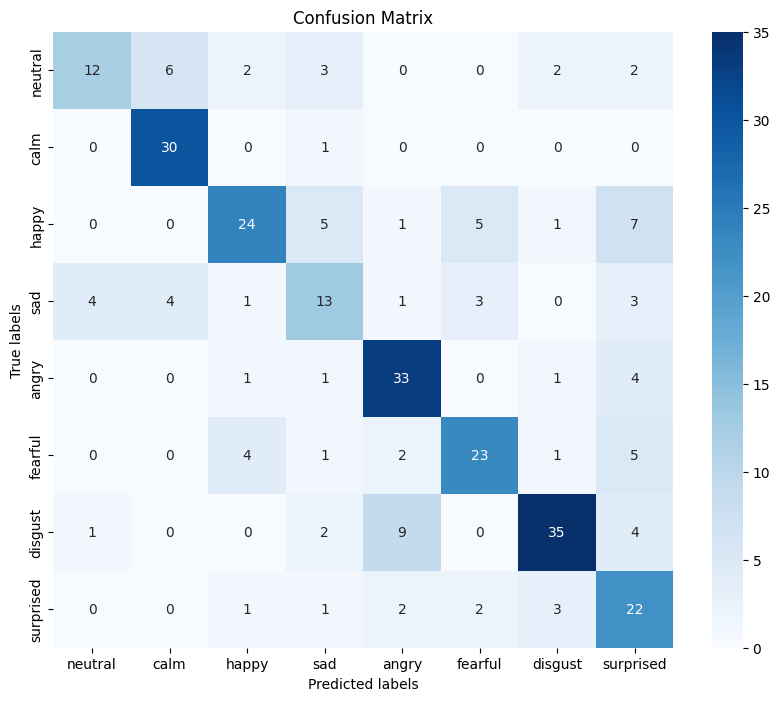

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

emotion_labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

def get_true_labels(dataset):
    true_labels = []
    for _, labels in dataset:
        true_labels.extend(labels.numpy())
    return np.array(true_labels)

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = get_true_labels(test_dataset)

conf_matrix = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Also Try a Transfer Learning Approach

I didn't try too many classification heads, so there is potential for better results. Fine tuning did perform better though.

In [29]:
class TFWav2Vec2ForAudioClassification_TransferLearning(layers.Layer):
    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(model_checkpoint, apply_spec_augment=False, from_pt=True)
        self.wav2vec2.trainable = False  # Freeze the pre-trained model

        # Additional layers
        self.pooling = layers.GlobalAveragePooling1D()
        self.dense1 = layers.Dense(512, activation="relu")
        self.dropout1 = layers.Dropout(0.5)
        self.dense2 = layers.Dense(256, activation="relu")
        self.dropout2 = layers.Dropout(0.5)
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        hidden_states = self.wav2vec2(inputs["input_values"])[0]
        x = self.pooling(hidden_states)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return self.final_layer(x)


In [30]:
def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification_TransferLearning(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # Optimizer
    optimizer = keras.optimizers.Adam()
    # Compile and return
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model


model = build_model()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['project_q.bias', 'quantizer.codevectors', 'project_hid.weight', 'project_hid.bias', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

In [31]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    batch_size=BATCH_SIZE,
)

Epoch 1/20
72/72 [==============================] - 33s 194ms/step - loss: 2.0670 - accuracy: 0.1753 - val_loss: 1.9365 - val_accuracy: 0.2361
Epoch 2/20
72/72 [==============================] - 8s 113ms/step - loss: 1.9596 - accuracy: 0.2118 - val_loss: 1.8787 - val_accuracy: 0.2153
Epoch 3/20
72/72 [==============================] - 8s 113ms/step - loss: 1.9019 - accuracy: 0.2378 - val_loss: 1.8362 - val_accuracy: 0.2778
Epoch 4/20
72/72 [==============================] - 8s 112ms/step - loss: 1.8700 - accuracy: 0.2639 - val_loss: 1.8277 - val_accuracy: 0.2951
Epoch 5/20
72/72 [==============================] - 8s 112ms/step - loss: 1.8465 - accuracy: 0.2804 - val_loss: 1.7944 - val_accuracy: 0.2882
Epoch 6/20
72/72 [==============================] - 8s 112ms/step - loss: 1.8150 - accuracy: 0.2873 - val_loss: 1.7987 - val_accuracy: 0.2569
Epoch 7/20
72/72 [==============================] - 8s 112ms/step - loss: 1.7937 - accuracy: 0.2812 - val_loss: 1.7655 - val_accuracy: 0.2708
Epoch